In [1]:
from rawio.IO import *
import ROOT 
import root_numpy

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
pd.set_option("display.max_row", 100)
import numpy as np

import sys
import os, os.path 
import fnmatch
import glob

Welcome to JupyROOT 6.24/06


In [2]:
# Function to convert our C-style char[] strings to RDataFrame std::strings
# Why doesn't ROOT do this automatically (or have an option to do so)?
ROOT.gInterpreter.Declare("""
std::string convertToString(const ROOT::VecOps::RVec<Char_t>& vec) {
    std::string s;
    size_t length = vec.size();
    for (size_t i = 0; vec[i]!='\\0'; ++i) {   // Takes care of arrays with extra NUL at end
        s += vec[i];
        }
    return s;
    }
 """)

True

In [3]:
## NOTE: This version is for ROOT 6.24 and earlier; in ROOT 6.26, use rdf.Redefine() 
def cast_columns(rdf):
    """Convert char[] (C-style string) TBranches to strings, with new column names
       Usage: fixed_rdf = cast_columns(ROOT::RDataFrame(.....))
       After calling data = fixed_rdf.AsNumpy(), the original column name can be restored with
       data['Branch'] = data.pop('Branch_cast')
    """
    for column in rdf.GetColumnNames():
        if rdf.GetColumnType(column) == "ROOT::VecOps::RVec<Char_t>":
            rdf = rdf.Define(f"{column}_cast", f"convertToString({column})")
            # NOTE: No way to rename or delete a column before 6.26; do it later via Numpy 
    return rdf

In [4]:
def cast_array(data):
    """Convert RDataFrame array columns to Numpy arrays, can replace in situ
       Usage: numpy['Branch'] = cast_array(numpy['Branch'])
    """
    casted_row = []
    for row in data:
        casted_row.append([i for i in row])
    return np.array(casted_row)

In [5]:
def getSharingData(file):
    """Extract useful hit and energy-sharing information from specified file
       Usage: numpyData = getSharingData('myRootFile.root')
    """
    branches = ['EventNum','TrkStep','BoundaryStatus','PName','X3','Y3','Z3','Edep','PhononE','ChargeQ']
    rdf = cast_columns(ROOT.RDataFrame("G4SimDir/mczip0", file, branches))
    data = rdf.AsNumpy(branches+['PName_cast'])
    data['PName'] = data.pop('PName_cast')
    data['PhononE'] = cast_array(data['PhononE'])
    data['ChargeQ'] = cast_array(data['ChargeQ'])
    return data

In [6]:
def getEventData(file):
    """Extract event summary data (hits per event, elapsed time, etc.)"""
    branches = ['EventNum','Elapsed','HitsPerEvent']
    rdf = cast_columns(ROOT.RDataFrame("G4SimDir/mcevent", file, branches))
    data = rdf.AsNumpy(branches)
    return data

In [40]:
# Will want to get binning in getTraces() to eliminate this hardcoding
# These are for iZIP5 and CDMSlite
chargeBins = np.arange(-409600.0, 1228800, 800) * 1e-3
phononBins = np.arange(-819200.0, 5734400, 1600) * 1e-3
# These are for HV100mm
###phononBins = np.arange(-26880000.0, 25548800, 1600) * 1e-3

# Will want to get channel names from G4SettingsInfo/Geometry.ChanName list
# Will want to get channel names from G4SettingsInfo/Geometry.ChanName list
iZIP5qChans = ['Qo1','Qi1','Qo2','Qi2']
iZIP5phChans = ['PAS1','PBS1','PCS1','PDS1','PAS2','PBS2','PCS2','PDS2']
HVqChans = []
HVphChans = ['PAS1','PBS1','PCS1','PDS1','PES1','PFS1','PAS2','PBS2','PCS2','PDS2','PES2','PFS2']

In [41]:
# Generic function used by getTES() and getFET() below
# tree="g4dmcTES" or "g4dmcFET"; function will take care of directory
def getTraces(file, tree, chans, dtype=0):
    traces = { chan: list() for chan in chans }      # Separate empty lists for each key

    data = root_numpy.root2array(file, treename="G4SimDir/"+tree, 
                                 branches = ['EventNum','Trace','ChanName'],
                                 selection=f"DataType=={dtype}")
    
    # Copy traces for each event into new array indexed by event number
    for i in range(len(data)):
        for ch in traces.keys():
            if data['ChanName'][i] == bytes(ch, "ascii"):
                traces[ch].append(data['Trace'][i])
    
    for ch in traces.keys():
        traces[ch] = np.array(traces[ch])

    return traces

In [42]:
def getTES(file, chans, dtype=0):
    tes = getTraces(file, "g4dmcTES", chans, dtype)

    # Convert TES traces from downward to upward going, remove baseline offset
    for ch in tes.keys():
        tes[ch] = np.array([max(tr)-tr for tr in tes[ch]])
        
    return tes

In [43]:
def getFET(file, chans, dtype=0):
    fet = getTraces(file, "g4dmcFET", chans, dtype)
    return fet

In [44]:
pulsesFast = 'data/FastDMC/Pulses-10keV-elog1752_51230925_0000.root'
pulsesFull = 'data/FastDMC/Pulses-10keV-V09-13-00_51230925_0000.root'

In [45]:
fastFET = getFET(pulsesFast, iZIP5qChans)
fullFET = getFET(pulsesFull, iZIP5qChans)

Text(0.5, 1.0, 'Trace for Qi1 in Event 0')

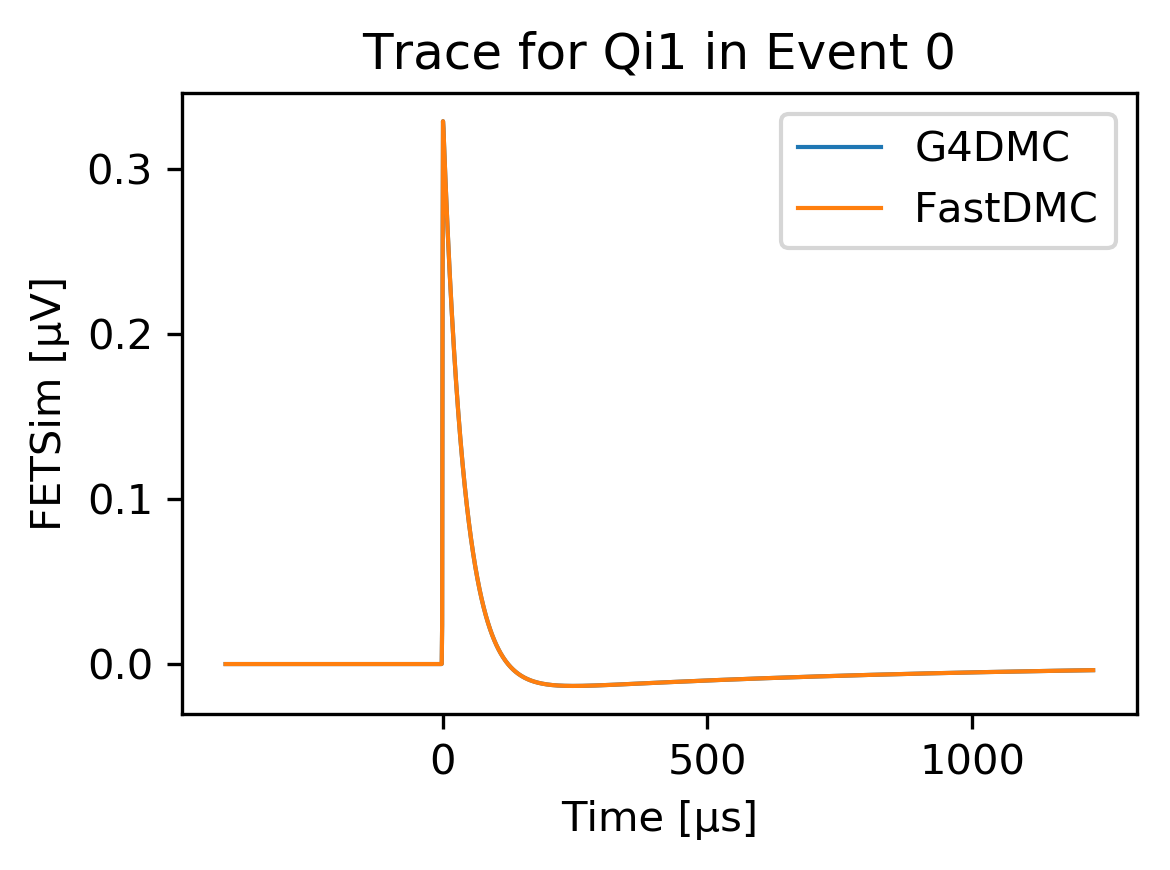

In [46]:
event = 0
#### Make overlay of QIS1, which is the cleanest trace
fig1, axes = plt.subplots(1,1,figsize=(4,3), dpi=300)
fig1.set_tight_layout(True)

axes.plot(chargeBins, fullFET['Qi1'][event], lw=1, color='C0', label='G4DMC')
axes.plot(chargeBins, fastFET['Qi1'][event], lw=1, color='C1', label='FastDMC')
axes.legend(loc="upper right")
axes.set_xlabel("Time [\u03BCs]")
axes.set_ylabel("FETSim [\u03BCV]")
axes.set_title('Trace for Qi1 in Event ' + str(event))

In [47]:
fig1.savefig("FastDMC_Qi1.eps")
fig1.savefig("FastDMC_Qi1.png")

In [61]:
iZIP5File = 'data/FastDMC/FastDMC-356keV_00230930_0000.root'
HV100mmFile = 'data/FastDMC/HV100mmSi-Sharing-10keV_00230928_000000.root'

In [62]:
iZIP5data = getSharingData(iZIP5File)
HV100mmData = getSharingData(HV100mmFile)

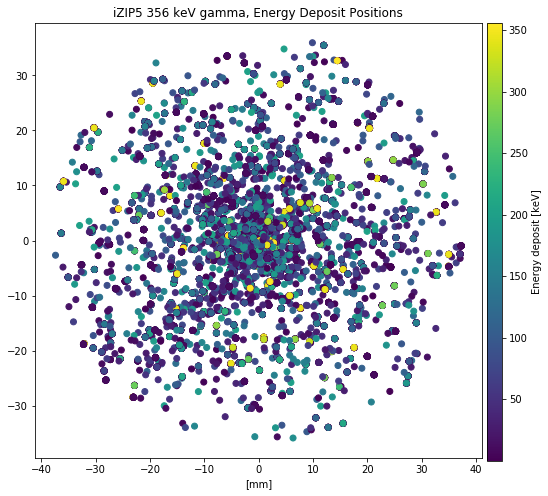

In [50]:
plt.subplots(figsize=(8,8))
plt.scatter(iZIP5data['X3']*1e3,iZIP5data['Y3']*1e3,c=iZIP5data['Edep']/1e3)
plt.title("iZIP5 356 keV gamma, Energy Deposit Positions")
plt.xlabel("[mm]")
cax = plt.axes([0.91, 0.12, 0.025, 0.76])
bar = plt.colorbar(cax=cax)
bar.set_label("Energy deposit [keV]")
plt.savefig("iZIP5_sharing-hits.png")

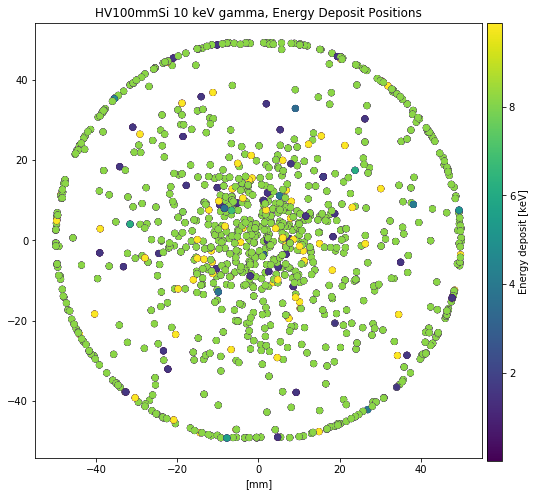

In [57]:
plt.subplots(figsize=(8,8))
plt.scatter(HV100mmData['X3']*1e3,HV100mmData['Y3']*1e3,c=HV100mmData['Edep']/1e3)
plt.title("HV100mmSi 10 keV gamma, Energy Deposit Positions")
plt.xlabel("[mm]")
cax = plt.axes([0.91, 0.12, 0.025, 0.76])
bar = plt.colorbar(cax=cax)
bar.set_label("Energy deposit [keV]")
plt.savefig("HV100mm_sharing-hits.png")

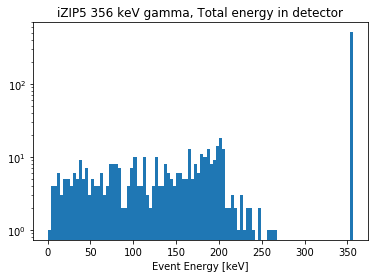

In [52]:
Etot = np.hstack([np.sum(iZIP5data['Edep'][iZIP5data['EventNum']==evt])/1e3 for evt in np.unique(iZIP5data['EventNum'])])

plt.hist(Etot,bins=100,log=True)
plt.xlabel("Event Energy [keV]")
plt.title("iZIP5 356 keV gamma, Total energy in detector")
plt.savefig("iZIP5-356keV_Etot.png")

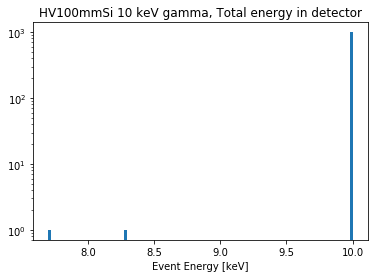

In [53]:
Etot = np.hstack([np.sum(HV100mmData['Edep'][HV100mmData['EventNum']==evt])/1e3 for evt in np.unique(HV100mmData['EventNum'])])

plt.hist(Etot,bins=100,log=True)
plt.xlabel("Event Energy [keV]")
plt.title("HV100mmSi 10 keV gamma, Total energy in detector")
plt.savefig("HV100mm-10keV_Etot.png")

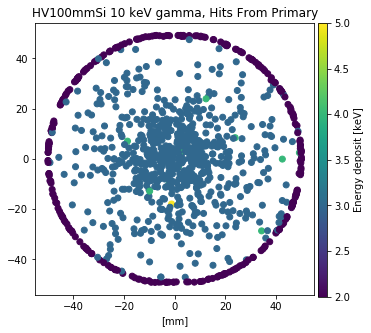

In [67]:
incident = (np.floor(HV100mmData['TrkStep']/100000) == 1)
plt.subplots(figsize=(5,5))
plt.scatter(HV100mmData['X3'][incident]*1e3,HV100mmData['Y3'][incident]*1e3,c=HV100mmData['TrkStep'][incident]%100000)
plt.title("HV100mmSi 10 keV gamma, Hits From Primary")
plt.xlabel("[mm]")
cax = plt.axes([0.91, 0.12, 0.025, 0.76])
bar = plt.colorbar(cax=cax)
bar.set_label("Energy deposit [keV]")
plt.savefig("HV100mm_primaryOnlyHits.png")